# Loading the Dataset

In [1]:
import pandas as pd

# Load CSV file
df = pd.read_csv("../data/raw/reviews.csv")

# Check first rows
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [2]:
# Focus only on the Review column:

reviews = df['Review'].dropna() # remove missing reviews

# STEP 1: Data preprocessing and Cleaning

* ## Lowercasing

In [4]:
reviews = reviews.str.lower()
print("Success!")

Success!


* ## Remove Punctuation and Special Characters

In [3]:
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

reviews = reviews.apply(clean_text)
print("Done!")

Done!


* ## Sentence Segmentation

In [4]:
import spacy

# Load English model
nlp = spacy.load("en_core_web_sm")
def split_sentences(text):
    doc = nlp(str(text))  # ensure text is string
    return [sent.text for sent in doc.sents]
# Assuming your reviews are in a pandas Series called 'reviews'
segmented_reviews = reviews.apply(split_sentences)

# Check first few rows
segmented_reviews.head()
print("Done")

Done


* ## Tokenization

In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab') 
# Tokenize all reviews
tokens = segmented_reviews.apply(lambda sentences: [word_tokenize(sent) for sent in sentences])
tokens.head()
print("done")

[nltk_data] Downloading package punkt to /home/saron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/saron/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


done


* ## Stopword Removal

In [10]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Flatten the tokens if you have nested lists (sentences → words)
flat_tokens = [token for review in tokens for sentence in review for token in sentence]
# Remove stopwords
filtered_tokens = [word.lower() for word in flat_tokens if word.lower() not in stop_words and word.isalpha()]
print(filtered_tokens[:50])  # show first 50 tokens
print("done")

['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friendly', 'support', 'please', 'ignore', 'previous', 'negative', 'rating', 'app', 'super', 'great', 'give', 'five', 'stars', 'popup', 'get', 'best', 'spotify', 'experience', 'android', 'annoying', 'please', 'lets', 'get', 'rid', 'really', 'buggy', 'terrible', 'use', 'recently', 'dear', 'spotify', 'get', 'songs', 'didnt', 'put', 'playlist', 'shuffle', 'play', 'player']
done


[nltk_data] Downloading package stopwords to /home/saron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* ## Lemmatization (dictionary-based, accurate)

In [11]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
# Lemmatize
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
print(lemmatized_tokens[:50])  # show first 50 lemmatized tokens
print("done")

[nltk_data] Downloading package wordnet to /home/saron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friendly', 'support', 'please', 'ignore', 'previous', 'negative', 'rating', 'app', 'super', 'great', 'give', 'five', 'star', 'popup', 'get', 'best', 'spotify', 'experience', 'android', 'annoying', 'please', 'let', 'get', 'rid', 'really', 'buggy', 'terrible', 'use', 'recently', 'dear', 'spotify', 'get', 'song', 'didnt', 'put', 'playlist', 'shuffle', 'play', 'player']
done


* ## Final Cleaned Text

In [12]:
# Reconstruct cleaned reviews from lemmatized tokens
token_counts = [sum(len(sent) for sent in review) for review in tokens]
cleaned_reviews = [
    ' '.join(lemmatized_tokens[start_idx:start_idx + count])
    for start_idx, count in zip([sum(token_counts[:i]) for i in range(len(token_counts))], token_counts)
]
cleaned_reviews = pd.Series(cleaned_reviews, index=df['Review'].dropna().index)
print(cleaned_reviews[:5])
print("done")

0    great music service audio high quality app eas...
1    give five star popup get best spotify experien...
2    buggy terrible use recently dear spotify get s...
3    app restart forgets playing fix issue love sel...
4    provided song youre listening still extremely ...
dtype: object
done


* ## Saving to a processed file

In [13]:
import pandas as pd

df['cleaned_review'] = cleaned_reviews
df.to_csv("../data/processed/processed_reviews.csv", index=False)
print("done")

done


In [14]:
import pandas as pd

df['cleaned_review'] = cleaned_reviews
df.to_csv("../data/processed/processed_reviews.csv", index=False)
print("done")
df[['cleaned_review']].to_csv("../data/processed/cleaned_text_only.csv", index=False)

done


# Step 2: Sentiment Analysis

In [15]:
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Load your processed CSV (adjust the path)
df = pd.read_csv("../data/processed/processed_reviews.csv")   
df.head()

/home/saron/MySpace/iCog/Trainings/2nd_training_NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Time_submitted,Review,Rating,Total_thumbsup,Reply,cleaned_review
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,great music service audio high quality app eas...
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,give five star popup get best spotify experien...
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,buggy terrible use recently dear spotify get s...
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,app restart forgets playing fix issue love sel...
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,provided song youre listening still extremely ...


* ## Create the DistilBERT sentiment pipeline

In [16]:
# create pipeline 
import torch
device = 0 if torch.cuda.is_available() else -1

# model choice: DistilBERT finetuned on SST-2 (binary POS/NEG)
classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device
)

print("Pipeline ready. Device:", "GPU" if device==0 else "CPU")
print("Done")

Device set to use cpu


Pipeline ready. Device: CPU
Done


* ## Run the model in batch

In [17]:
# run inference in batches and collect raw results
text_col = "cleaned_review"
# Ensure all texts are strings
texts = df[text_col].astype(str).tolist()

N = len(texts)
batch_size = 32           # adjust up/down depending on memory (bigger = faster if you have RAM)
raw_outputs = []          # list to collect results for each text

for i in tqdm(range(0, N, batch_size), desc="Running classifier"):
    batch = texts[i : i + batch_size]
    # return_all_scores=True gives a list of label/score dicts for each example
    batch_out = classifier(batch, truncation=True, return_all_scores=True)
    raw_outputs.extend(batch_out)

# Sanity: same length?
assert len(raw_outputs) == N
print("Done inference; results for first item:", raw_outputs[0])

Running classifier:   0%|                                                                                                               | 0/1925 [00:00<?, ?it/s]/home/saron/MySpace/iCog/Trainings/2nd_training_NLP/.venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Running classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1925/1925 [13:50<00:00,  2.32it/s]

Done inference; results for first item: [{'label': 'NEGATIVE', 'score': 0.007652156986296177}, {'label': 'POSITIVE', 'score': 0.9923478364944458}]


* ## Convert outputs to pos/neg probabilities and apply neutral rules

In [18]:
# convert outputs to pos/neg probabilities and apply neutral band rules
pos_probs = []
neg_probs = []
labels = []
confidences = []

# thresholds you can tweak
MAX_PROB_THRESHOLD = 0.60   # if the top probability < this -> NEUTRAL
DIFF_THRESHOLD = 0.20       # if pos-neg diff < this -> NEUTRAL

for row in raw_outputs:
    # row example: [{'label': 'NEGATIVE','score':0.12}, {'label':'POSITIVE','score':0.88}]
    probs = {d["label"]: float(d["score"]) for d in row}
    pos = probs.get("POSITIVE", 0.0)
    neg = probs.get("NEGATIVE", 0.0)
    pos_probs.append(pos)
    neg_probs.append(neg)

    max_prob = max(pos, neg)
    diff = abs(pos - neg)

    if (max_prob < MAX_PROB_THRESHOLD) or (diff < DIFF_THRESHOLD):
        label = "NEUTRAL"
        conf = 1.0 - diff   # heuristic: small diff -> more neutral (0..1)
    else:
        label = "POSITIVE" if pos > neg else "NEGATIVE"
        conf = max_prob

    labels.append(label)
    confidences.append(conf)

# attach to df
df["sent_pos_prob"] = pos_probs
df["sent_neg_prob"] = neg_probs
df["sent_confidence"] = confidences
df["Sentiment"] = labels

# Quick peek
print(df[[text_col, "Sentiment", "sent_pos_prob", "sent_neg_prob", "sent_confidence"]].head(8).to_string(index=False))


                                                                                                                                                                                                                                                                                                                                                                                                          cleaned_review Sentiment  sent_pos_prob  sent_neg_prob  sent_confidence
                                                                                                                                                                                                                                                                                  great music service audio high quality app easy use also quick friendly support please ignore previous negative rating app super great  POSITIVE       0.992348       0.007652         0.992348
                                                                    

* ## Save with sentiment column

In [19]:

# Step 6: Save with sentiment column
out_path = "../data/processed/spotify_reviews_with_sentiment.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: ../data/processed/spotify_reviews_with_sentiment.csv


* ## Visualized Sentiment Analysis

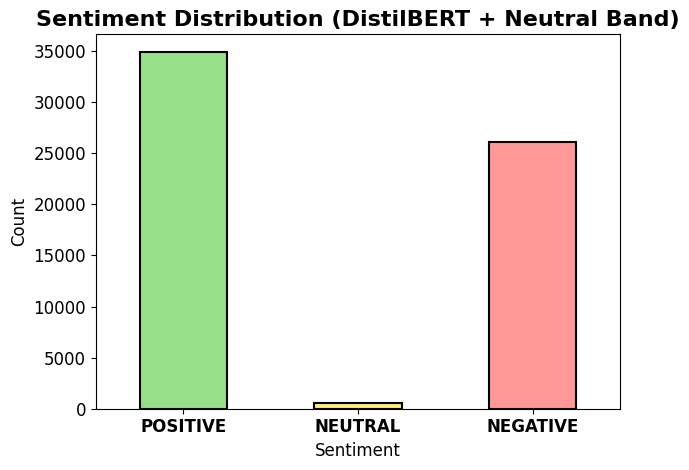

In [20]:
# Step 7: visualize counts

import matplotlib.pyplot as plt
# Reorder counts
counts = df["Sentiment"].value_counts().reindex(["POSITIVE", "NEUTRAL", "NEGATIVE"]).fillna(0)

# Custom colors for each sentiment
colors = ["#98df8a", "#ffee7a", "#ff9896"]  # light green, light yellow, light red


# Plot
counts.plot(kind="bar", color=colors, rot=0, edgecolor='black', linewidth=1.5)

plt.title("Sentiment Distribution (DistilBERT + Neutral Band)", fontsize=16, weight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


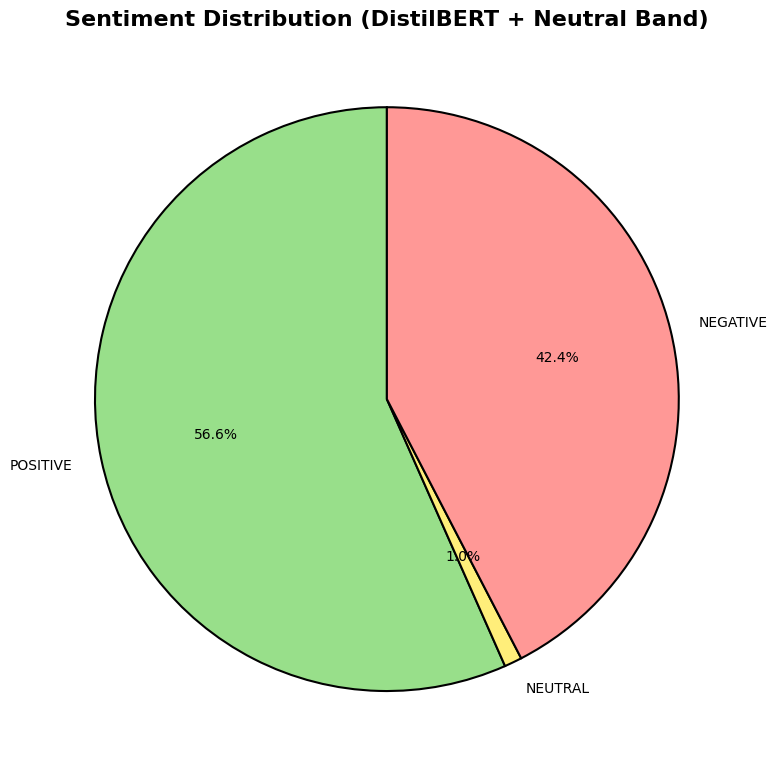

In [21]:
import matplotlib.pyplot as plt

# Reorder counts
counts = df["Sentiment"].value_counts().reindex(["POSITIVE", "NEUTRAL", "NEGATIVE"]).fillna(0)

# Custom colors for each sentiment
colors = ["#98df8a", "#ffee7a", "#ff9896"]  # light green, light yellow, light red


# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=counts.index,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

plt.title("Sentiment Distribution (DistilBERT + Neutral Band)", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


* ## Compare Rating and Sentiment Column

In [23]:

# Optional: compare to Rating column if present (1-5)
def rating_to_sentiment(stars):
    try:
        stars = float(stars)
    except:
        return None
    if stars >= 4: return "POSITIVE"
    if stars <= 2: return "NEGATIVE"
    return "NEUTRAL"

if "Rating" in df.columns:
    df["Rating_Sentiment"] = df["Rating"].apply(rating_to_sentiment)
    # compute simple agreement (ignoring nulls)
    valid = df.dropna(subset=["Rating_Sentiment"])
    agreement = (valid["Sentiment"] == valid["Rating_Sentiment"]).mean()
    print(f"Agreement vs Rating (approx): {agreement:.2%}")
    print(valid[["Rating","Rating_Sentiment","Sentiment"]].head(6).to_string(index=False))

Agreement vs Rating (approx): 43.90%
 Rating Rating_Sentiment Sentiment
      5         POSITIVE  POSITIVE
      5         POSITIVE  NEGATIVE
      4         POSITIVE  NEGATIVE
      1         NEGATIVE  NEGATIVE
      1         NEGATIVE  NEGATIVE
      3          NEUTRAL  NEGATIVE


# Step 3: Thematic analysis

In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
print("done")

done


In [3]:
# --- Load cleaned dataset ---
df = pd.read_csv("../data/processed/cleaned_text_only.csv")  # your cleaned reviews file
reviews = df['cleaned_review'].fillna("")
print(f"Total reviews: {len(reviews)}")
reviews[:5]  # check the first few reviews

Total reviews: 61594


0    great music service audio high quality app eas...
1    give five star popup get best spotify experien...
2    buggy terrible use recently dear spotify get s...
3    app restart forgets playing fix issue love sel...
4    provided song youre listening still extremely ...
Name: cleaned_review, dtype: object

* ## TF-IDF Vectorization

In [4]:
# --- Create TF-IDF features ---
vectorizer = TfidfVectorizer(
    max_df=0.85,        # ignore words that appear in >85% of reviews
    min_df=2,           # ignore words appearing in <2 reviews
    ngram_range=(1,2),  # include unigrams (single words) and bigrams (2-word phrases)
    stop_words='english'  # remove common stop words like 'the', 'and'
)

tfidf_matrix = vectorizer.fit_transform(reviews)
feature_names = np.array(vectorizer.get_feature_names_out())
print(f"Total features created: {len(feature_names)}")

Total features created: 83854


* ## Extract top keywords

In [5]:
# --- Sum TF-IDF scores across all reviews to get most important words ---
tfidf_sum = tfidf_matrix.sum(axis=0).A1  # sum scores for each word/phrase
top_n = 20
top_indices = tfidf_sum.argsort()[::-1][:top_n]
top_keywords = feature_names[top_indices]
top_scores = tfidf_sum[top_indices]

# Display top keywords
for word, score in zip(top_keywords, top_scores):
    print(f"{word}: {score:.2f}")


app: 1607.51
song: 1576.40
music: 1280.86
spotify: 1000.47
play: 826.73
ad: 702.07
playlist: 654.20
like: 634.83
listen: 617.24
love: 604.38
premium: 583.70
good: 578.12
great: 506.13
dont: 494.47
want: 470.04
time: 467.16
playing: 463.23
im: 460.99
update: 448.28
use: 434.21


* ## Visualize top keywords

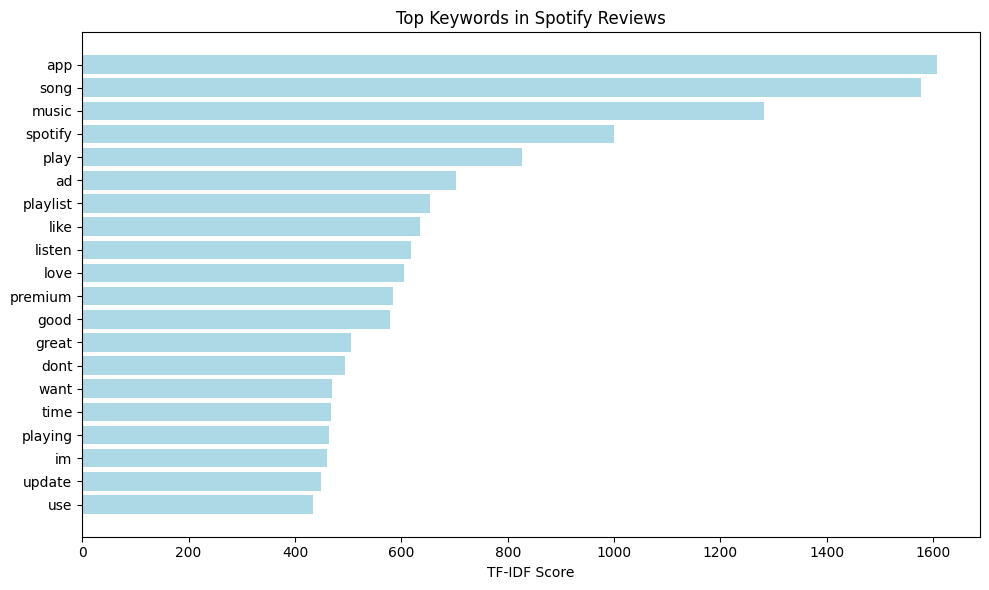

In [6]:
# --- Plot top keywords ---
plt.figure(figsize=(10,6))
plt.barh(top_keywords[::-1], top_scores[::-1], color='lightblue')  # reverse for top-down
plt.xlabel("TF-IDF Score")
plt.title("Top Keywords in Spotify Reviews")
plt.tight_layout()
plt.show()


* ## Grouping the top words

In [7]:
# Example theme groups
themes = {
    "App & Usability": ["app", "use", "time", "im", "update"],  
    # app functionality, ease of use, general usage comments
    "Music & Songs": ["song", "music", "play", "listen", "playing", "playlist"],  
    # about songs, music, playback, playlist experience
    "User Satisfaction/Sentiment": ["love", "good", "great", "like", "want", "dont"],  
    # expressing positive feelings or preferences
    "Ads & Premium": ["ad", "premium"],  
    # about advertisements or subscription/premium features
    "Spotify Branding": ["spotify"]  
    # mentions the app name directly
}

# Count how many times theme keywords appear in all reviews
theme_counts = {}
for theme, keywords in themes.items():
    count = sum(reviews.str.contains('|'.join(keywords), case=False))
    theme_counts[theme] = count

theme_counts

{'App & Usability': 27620,
 'Music & Songs': 27938,
 'User Satisfaction/Sentiment': 22037,
 'Ads & Premium': 19543,
 'Spotify Branding': 13163}

* ## Visualizing Theme analysis

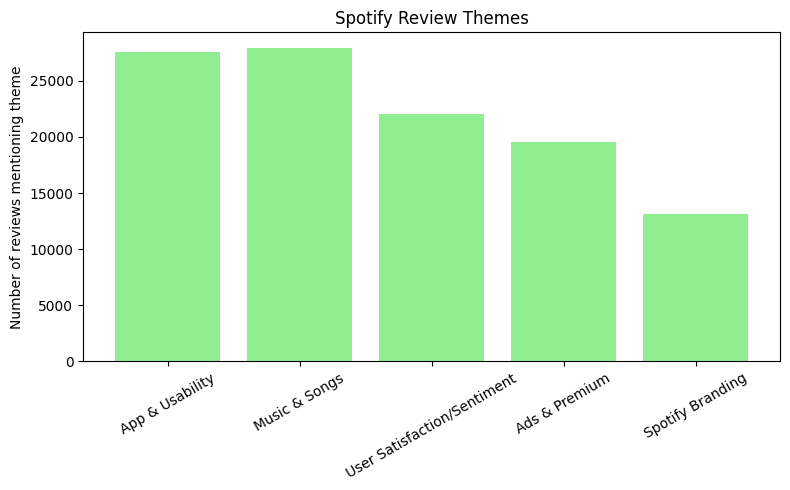

In [8]:
# --- Plot theme distribution ---
plt.figure(figsize=(8,5))
plt.bar(theme_counts.keys(), theme_counts.values(), color='lightgreen')
plt.ylabel("Number of reviews mentioning theme")
plt.title("Spotify Review Themes")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Additional tool comparision

In [2]:
# VADER
import nltk
import pandas as pd
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

df = pd.read_csv("../data/processed/processed_reviews.csv")   
# Step 2: Initialize the analyzer
sia = SentimentIntensityAnalyzer()

# Step 3: Analyze sentiment for each cleaned review
df['VADER_scores'] = df['cleaned_review'].apply(lambda x: sia.polarity_scores(str(x)))

# Step 4: Extract compound score and assign label
def vader_label(score):
    compound = score['compound']
    if compound >= 0.05:
        return "POSITIVE"
    elif compound <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

df['VADER_sentiment'] = df['VADER_scores'].apply(vader_label)

# Save the DataFrame with VADER sentiment
df.to_csv("/home/saron/MySpace/iCog/Trainings/2nd_training_NLP/data/processed/spotify_reviews_with_vader_sentiment.csv", index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/saron/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
#TextBlob
#Install and import
from textblob import TextBlob

# Step 2: Compute polarity for each cleaned review
df['TextBlob_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Step 3: Assign sentiment based on polarity
def textblob_label(polarity):
    if polarity > 0.05:
        return "POSITIVE"
    elif polarity < -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

df['TextBlob_sentiment'] = df['TextBlob_polarity'].apply(textblob_label)
df.to_csv("../data/processed/spotify_reviews_with_textblob_sentiment.csv", index=False)
print("done")

done


In [4]:
# Compare sentiment counts
import pandas as pd

print("VADER Sentiment Counts:")
print(df['VADER_sentiment'].value_counts())

print("\nTextBlob Sentiment Counts:")
print(df['TextBlob_sentiment'].value_counts())

df = pd.read_csv("../data/processed/spotify_reviews_with_sentiment.csv")  # make sure this is the file with DistilBERT results
print("\nDistilBERT Sentiment Counts:")
print(df['Sentiment'].value_counts())


VADER Sentiment Counts:
VADER_sentiment
NEUTRAL     29310
POSITIVE    24635
NEGATIVE     7649
Name: count, dtype: int64

TextBlob Sentiment Counts:
TextBlob_sentiment
NEUTRAL     33596
POSITIVE    21989
NEGATIVE     6009
Name: count, dtype: int64

DistilBERT Sentiment Counts:
Sentiment
POSITIVE    34883
NEGATIVE    26110
NEUTRAL       601
Name: count, dtype: int64


* ## Visualizing the three tools

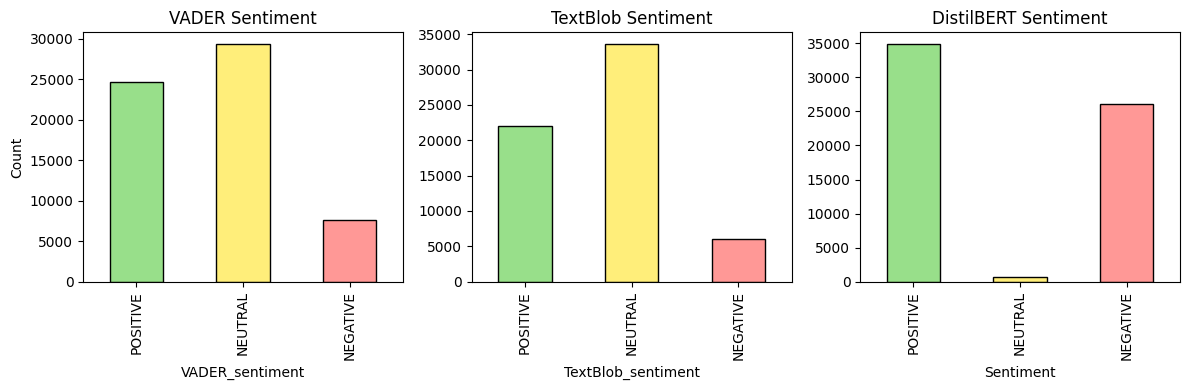

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

sentiments = ['POSITIVE','NEUTRAL','NEGATIVE']
colors = ["#98df8a", "#ffee7a", "#ff9896"]

# Load CSVs
df_vader = pd.read_csv("../data/processed/spotify_reviews_with_vader_sentiment.csv")
df_textblob = pd.read_csv("../data/processed/spotify_reviews_with_textblob_sentiment.csv")
df_distil = pd.read_csv("../data/processed/spotify_reviews_with_sentiment.csv")

plt.figure(figsize=(12,4))

# VADER
plt.subplot(1,3,1)
df_vader['VADER_sentiment'].value_counts().reindex(sentiments, fill_value=0).plot(
    kind='bar', color=colors, edgecolor='black')
plt.title("VADER Sentiment")
plt.ylabel("Count")

# TextBlob
plt.subplot(1,3,2)
df_textblob['TextBlob_sentiment'].value_counts().reindex(sentiments, fill_value=0).plot(
    kind='bar', color=colors, edgecolor='black')
plt.title("TextBlob Sentiment")

# DistilBERT
plt.subplot(1,3,3)
df_distil['Sentiment'].value_counts().reindex(sentiments, fill_value=0).plot(
    kind='bar', color=colors, edgecolor='black')
plt.title("DistilBERT Sentiment")

plt.tight_layout()
plt.show()


* ## compare Rating and Sentiment Column in vader and textblob tool

In [2]:
import pandas as pd

# Function to convert star rating to sentiment
def rating_to_sentiment(stars):
    try:
        stars = float(stars)
    except:
        return None
    if stars >= 4: 
        return "POSITIVE"
    if stars <= 2: 
        return "NEGATIVE"
    return "NEUTRAL"

# Function to compute agreement with Rating
def compute_agreement(df, sentiment_col):
    if "Rating" not in df.columns:
        print("No Rating column found!")
        return
    valid = df.dropna(subset=[sentiment_col, "Rating"])
    valid["Rating_Sentiment"] = valid["Rating"].apply(rating_to_sentiment)
    agreement = (valid[sentiment_col] == valid["Rating_Sentiment"]).mean()
    print(f"Agreement of {sentiment_col} vs Rating: {agreement:.2%}")
    print(valid[["Rating", "Rating_Sentiment", sentiment_col]].head(6).to_string(index=False))

# Load CSVs
df_vader = pd.read_csv("../data/processed/spotify_reviews_with_vader_sentiment.csv")
df_textblob = pd.read_csv("../data/processed/spotify_reviews_with_textblob_sentiment.csv")


# Compute agreement
compute_agreement(df_vader, "VADER_sentiment")
compute_agreement(df_textblob, "TextBlob_sentiment")


Agreement of VADER_sentiment vs Rating: 28.78%
 Rating Rating_Sentiment VADER_sentiment
      5         POSITIVE        POSITIVE
      5         POSITIVE        POSITIVE
      4         POSITIVE         NEUTRAL
      1         NEGATIVE        POSITIVE
      1         NEGATIVE        POSITIVE
      3          NEUTRAL        POSITIVE
Agreement of TextBlob_sentiment vs Rating: 26.49%
 Rating Rating_Sentiment TextBlob_sentiment
      5         POSITIVE           POSITIVE
      5         POSITIVE           POSITIVE
      4         POSITIVE           NEGATIVE
      1         NEGATIVE           POSITIVE
      1         NEGATIVE           NEGATIVE
      3          NEUTRAL            NEUTRAL
